In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperatures
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperatures
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperatures
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 3
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df) 
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 3
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

3
179
(84, 1972)
(11, 1972)


[I 2025-05-22 01:38:31,804] A new study created in memory with name: no-name-bc433e4d-8dde-448d-b0f2-4484fd0a46f8
[I 2025-05-22 01:40:06,630] Trial 0 finished with value: 0.11044141203165055 and parameters: {'lr': 0.018711588412268013, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.10040437284918756}. Best is trial 0 with value: 0.11044141203165055.


Cross Validation Accuracies:
[0.09453275054693222, 0.0767032727599144, 0.08624859154224396, 0.11237692087888718, 0.18234552443027496]
Mean Cross Validation Accuracy:
0.11044141203165055
Standard Deviation of Cross Validation Accuracy:
0.03781689487337325


[I 2025-05-22 01:42:38,657] Trial 1 finished with value: 0.07981936186552048 and parameters: {'lr': 0.0034399848322090726, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24907178165033295}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.06010555848479271, 0.056091006845235825, 0.09431163966655731, 0.10693573951721191, 0.08165286481380463]
Mean Cross Validation Accuracy:
0.07981936186552048
Standard Deviation of Cross Validation Accuracy:
0.01949540798021731


[I 2025-05-22 01:48:02,003] Trial 2 finished with value: 0.15403054505586625 and parameters: {'lr': 0.0017875675645214156, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.47315539407110696}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.19679445028305054, 0.09201309084892273, 0.17767560482025146, 0.1227344200015068, 0.18093515932559967]
Mean Cross Validation Accuracy:
0.15403054505586625
Standard Deviation of Cross Validation Accuracy:
0.03984296871537695


[I 2025-05-22 01:56:51,022] Trial 3 finished with value: 0.1098497062921524 and parameters: {'lr': 0.04861032670956752, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.16010550707966692}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.07750771939754486, 0.12469775974750519, 0.10314759612083435, 0.13843309879302979, 0.10546235740184784]
Mean Cross Validation Accuracy:
0.1098497062921524
Standard Deviation of Cross Validation Accuracy:
0.02072508743333516


[I 2025-05-22 02:04:43,182] Trial 4 finished with value: 0.08125445395708084 and parameters: {'lr': 0.018755450056827955, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12417342904247537}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.060463450849056244, 0.05785362422466278, 0.0942014530301094, 0.10977400094270706, 0.08397974073886871]
Mean Cross Validation Accuracy:
0.08125445395708084
Standard Deviation of Cross Validation Accuracy:
0.01984077203996277


[I 2025-05-22 02:14:45,664] Trial 5 finished with value: 0.1716855525970459 and parameters: {'lr': 0.3081810171447005, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.29125987002229303}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.18566042184829712, 0.16327700018882751, 0.15353311598300934, 0.14939498901367188, 0.20656223595142365]
Mean Cross Validation Accuracy:
0.1716855525970459
Standard Deviation of Cross Validation Accuracy:
0.021488433846531985


[I 2025-05-22 02:23:09,462] Trial 6 finished with value: 0.1478281244635582 and parameters: {'lr': 0.003702569275115143, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.45318216703539704}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.13897497951984406, 0.12387610226869583, 0.18699012696743011, 0.16626377403736115, 0.12303563952445984]
Mean Cross Validation Accuracy:
0.1478281244635582
Standard Deviation of Cross Validation Accuracy:
0.025061047334037502


[I 2025-05-22 02:31:18,471] Trial 7 finished with value: 0.7607274889945984 and parameters: {'lr': 0.03368669610569956, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19154519943642284}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.7659717798233032, 0.6499992609024048, 0.96463942527771, 0.6806601285934448, 0.7423668503761292]
Mean Cross Validation Accuracy:
0.7607274889945984
Standard Deviation of Cross Validation Accuracy:
0.11010560030583992


[I 2025-05-22 02:37:37,810] Trial 8 finished with value: 0.08224720954895019 and parameters: {'lr': 0.006295270982330968, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.43256913898922533}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.06191662326455116, 0.0585591159760952, 0.09877634793519974, 0.10275979340076447, 0.08922416716814041]
Mean Cross Validation Accuracy:
0.08224720954895019
Standard Deviation of Cross Validation Accuracy:
0.01853167539901994


[I 2025-05-22 02:48:27,086] Trial 9 finished with value: 0.10968459993600846 and parameters: {'lr': 0.8098020710826794, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.305114066939955}. Best is trial 1 with value: 0.07981936186552048.


Cross Validation Accuracies:
[0.10638177394866943, 0.06565773487091064, 0.13963915407657623, 0.10451624542474747, 0.1322280913591385]
Mean Cross Validation Accuracy:
0.10968459993600846
Standard Deviation of Cross Validation Accuracy:
0.026005652134188012


[I 2025-05-22 02:57:56,603] Trial 10 finished with value: 0.07578645646572113 and parameters: {'lr': 0.12541476350164474, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2619380073495448}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.07882092893123627, 0.057852603495121, 0.07905153185129166, 0.09200606495141983, 0.0712011530995369]
Mean Cross Validation Accuracy:
0.07578645646572113
Standard Deviation of Cross Validation Accuracy:
0.011185638374074327


[I 2025-05-22 03:07:17,644] Trial 11 finished with value: 0.09016548544168472 and parameters: {'lr': 0.1450304863388647, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.260329681867326}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.07917921245098114, 0.1043732613325119, 0.09218111634254456, 0.09972038120031357, 0.07537345588207245]
Mean Cross Validation Accuracy:
0.09016548544168472
Standard Deviation of Cross Validation Accuracy:
0.011284697863650944


[I 2025-05-22 03:18:24,658] Trial 12 finished with value: 0.09660546109080315 and parameters: {'lr': 0.09833802533186893, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.34576930302685016}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.0529104508459568, 0.09052470326423645, 0.13117003440856934, 0.10810697823762894, 0.1003151386976242]
Mean Cross Validation Accuracy:
0.09660546109080315
Standard Deviation of Cross Validation Accuracy:
0.025639757679459807


[I 2025-05-22 03:30:09,813] Trial 13 finished with value: 0.08114173486828805 and parameters: {'lr': 0.001383960641932455, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.22844602968549899}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.06164993345737457, 0.057752374559640884, 0.09431455284357071, 0.10862934589385986, 0.08336246758699417]
Mean Cross Validation Accuracy:
0.08114173486828805
Standard Deviation of Cross Validation Accuracy:
0.019292568750693656


[I 2025-05-22 03:37:47,931] Trial 14 finished with value: 0.07874107509851455 and parameters: {'lr': 0.007805949544605243, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3580216131769124}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.05889899656176567, 0.05514382943511009, 0.09383087605237961, 0.10529430210590363, 0.08053737133741379]
Mean Cross Validation Accuracy:
0.07874107509851455
Standard Deviation of Cross Validation Accuracy:
0.019424421335363675


[I 2025-05-22 03:45:59,584] Trial 15 finished with value: 0.07906294763088226 and parameters: {'lr': 0.010573887373933956, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3708145824012299}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.059794530272483826, 0.055988192558288574, 0.0929596945643425, 0.1065036952495575, 0.08006862550973892]
Mean Cross Validation Accuracy:
0.07906294763088226
Standard Deviation of Cross Validation Accuracy:
0.019239759989969244


[I 2025-05-22 03:53:06,208] Trial 16 finished with value: 0.0768634594976902 and parameters: {'lr': 0.07856773449297129, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.38509339761369515}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.04733503982424736, 0.06903298199176788, 0.07450395822525024, 0.11747760325670242, 0.0759677141904831]
Mean Cross Validation Accuracy:
0.0768634594976902
Standard Deviation of Cross Validation Accuracy:
0.0227557563072268


[I 2025-05-22 04:01:04,009] Trial 17 finished with value: 0.0860906958580017 and parameters: {'lr': 0.2079689044396122, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4158567995020324}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.06799538433551788, 0.05339686572551727, 0.11224070191383362, 0.0880146399140358, 0.10880588740110397]
Mean Cross Validation Accuracy:
0.0860906958580017
Standard Deviation of Cross Validation Accuracy:
0.02280276795530798


[I 2025-05-22 04:09:12,736] Trial 18 finished with value: 0.08839071691036224 and parameters: {'lr': 0.07390940195145788, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.38985357932732617}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.07691910117864609, 0.0823025032877922, 0.11147847771644592, 0.10734626650810242, 0.06390723586082458]
Mean Cross Validation Accuracy:
0.08839071691036224
Standard Deviation of Cross Validation Accuracy:
0.018223406468081627


[I 2025-05-22 04:19:38,529] Trial 19 finished with value: 39.08999099731445 and parameters: {'lr': 0.4490170153272653, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3169958391879429}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[35.66727066040039, 28.2614803314209, 52.000389099121094, 28.97345542907715, 50.547359466552734]
Mean Cross Validation Accuracy:
39.08999099731445
Standard Deviation of Cross Validation Accuracy:
10.28849474934535


[I 2025-05-22 04:27:20,846] Trial 20 finished with value: 0.09020284712314605 and parameters: {'lr': 0.06953103980059658, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.185076043427149}. Best is trial 10 with value: 0.07578645646572113.


Cross Validation Accuracies:
[0.07230187207460403, 0.09008259326219559, 0.11208357661962509, 0.08089113235473633, 0.09565506130456924]
Mean Cross Validation Accuracy:
0.09020284712314605
Standard Deviation of Cross Validation Accuracy:
0.013532629924637834


[I 2025-05-22 04:36:39,749] Trial 21 finished with value: 0.07532901763916015 and parameters: {'lr': 0.01833737198633649, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3504357159825984}. Best is trial 21 with value: 0.07532901763916015.


Cross Validation Accuracies:
[0.056942299008369446, 0.05537116527557373, 0.08954886347055435, 0.09769114851951599, 0.07709161192178726]
Mean Cross Validation Accuracy:
0.07532901763916015
Standard Deviation of Cross Validation Accuracy:
0.016980947821358568


[I 2025-05-22 04:44:48,577] Trial 22 finished with value: 0.07231385186314583 and parameters: {'lr': 0.029029877312292028, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3189263286636507}. Best is trial 22 with value: 0.07231385186314583.


Cross Validation Accuracies:
[0.052364643663167953, 0.0542922243475914, 0.08167842775583267, 0.09280157834291458, 0.08043238520622253]
Mean Cross Validation Accuracy:
0.07231385186314583
Standard Deviation of Cross Validation Accuracy:
0.01610032774646411


[I 2025-05-22 04:52:06,715] Trial 23 finished with value: 0.07316426783800126 and parameters: {'lr': 0.027242804199931723, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.32416625343396815}. Best is trial 22 with value: 0.07231385186314583.


Cross Validation Accuracies:
[0.05588085949420929, 0.049927808344364166, 0.08397208899259567, 0.09690782427787781, 0.07913275808095932]
Mean Cross Validation Accuracy:
0.07316426783800126
Standard Deviation of Cross Validation Accuracy:
0.017634271179049518


[I 2025-05-22 04:58:54,868] Trial 24 finished with value: 0.0753254696726799 and parameters: {'lr': 0.01925868155686136, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3334653462547821}. Best is trial 22 with value: 0.07231385186314583.


Cross Validation Accuracies:
[0.05814134702086449, 0.05199701711535454, 0.0824204683303833, 0.10297419875860214, 0.08109431713819504]
Mean Cross Validation Accuracy:
0.0753254696726799
Standard Deviation of Cross Validation Accuracy:
0.01837161722403301


[I 2025-05-22 05:05:55,584] Trial 25 finished with value: 0.07074961215257644 and parameters: {'lr': 0.030601885931126005, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.33025986064330043}. Best is trial 25 with value: 0.07074961215257644.


Cross Validation Accuracies:
[0.05443110316991806, 0.05022553354501724, 0.08122804015874863, 0.0938713476061821, 0.0739920362830162]
Mean Cross Validation Accuracy:
0.07074961215257644
Standard Deviation of Cross Validation Accuracy:
0.01638570691923353


[I 2025-05-22 05:12:53,876] Trial 26 finished with value: 0.06786324605345725 and parameters: {'lr': 0.037018267643804115, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.29915486926028706}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.056132957339286804, 0.047603439539670944, 0.07462111115455627, 0.0995393916964531, 0.06141933053731918]
Mean Cross Validation Accuracy:
0.06786324605345725
Standard Deviation of Cross Validation Accuracy:
0.018103206478377883


[I 2025-05-22 05:20:01,023] Trial 27 finished with value: 0.06838193610310554 and parameters: {'lr': 0.03777014798714843, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2937004663731902}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.0560176819562912, 0.05161651596426964, 0.07251126319169998, 0.08493877947330475, 0.07682543992996216]
Mean Cross Validation Accuracy:
0.06838193610310554
Standard Deviation of Cross Validation Accuracy:
0.012620834001782542


[I 2025-05-22 05:26:50,263] Trial 28 finished with value: 0.08049035668373108 and parameters: {'lr': 0.04745668795621482, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.28367991610039595}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.06000511720776558, 0.05702686682343483, 0.09914816170930862, 0.10789337754249573, 0.07837826013565063]
Mean Cross Validation Accuracy:
0.08049035668373108
Standard Deviation of Cross Validation Accuracy:
0.020365071005025492


[I 2025-05-22 05:34:36,819] Trial 29 finished with value: 0.14539964944124223 and parameters: {'lr': 0.0087338848754338, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.22044337219955512}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.14140643179416656, 0.11194565892219543, 0.17419621348381042, 0.17864204943180084, 0.12080789357423782]
Mean Cross Validation Accuracy:
0.14539964944124223
Standard Deviation of Cross Validation Accuracy:
0.027107817998642966


[I 2025-05-22 05:41:40,411] Trial 30 finished with value: 0.1261914774775505 and parameters: {'lr': 0.013329528338197437, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.49738247524348483}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.13230299949645996, 0.09733862429857254, 0.19586704671382904, 0.11014518141746521, 0.09530353546142578]
Mean Cross Validation Accuracy:
0.1261914774775505
Standard Deviation of Cross Validation Accuracy:
0.037245325520376675


[I 2025-05-22 05:48:34,684] Trial 31 finished with value: 0.07143917009234428 and parameters: {'lr': 0.03489590789355444, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2844419232454058}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.050732359290122986, 0.0584186352789402, 0.08017856627702713, 0.1047353744506836, 0.06313091516494751]
Mean Cross Validation Accuracy:
0.07143917009234428
Standard Deviation of Cross Validation Accuracy:
0.019247585358739477


[I 2025-05-22 05:55:32,192] Trial 32 finished with value: 0.06838422790169715 and parameters: {'lr': 0.040983201499953735, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.29024836898464135}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.05193106085062027, 0.046226415783166885, 0.06885607540607452, 0.10444606095552444, 0.07046152651309967]
Mean Cross Validation Accuracy:
0.06838422790169715
Standard Deviation of Cross Validation Accuracy:
0.020330612173179448


[I 2025-05-22 06:01:50,566] Trial 33 finished with value: 0.08415217325091362 and parameters: {'lr': 0.04811873871577013, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23908549074535795}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.05753990635275841, 0.09623711556196213, 0.09525468200445175, 0.10539596527814865, 0.06633319705724716]
Mean Cross Validation Accuracy:
0.08415217325091362
Standard Deviation of Cross Validation Accuracy:
0.018688707248117917


[I 2025-05-22 06:10:58,071] Trial 34 finished with value: 0.07826271578669548 and parameters: {'lr': 0.055323878855451335, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2743637610646922}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.06645990908145905, 0.07328756153583527, 0.07218628376722336, 0.12304651737213135, 0.056333307176828384]
Mean Cross Validation Accuracy:
0.07826271578669548
Standard Deviation of Cross Validation Accuracy:
0.02318391372676535


[I 2025-05-22 06:18:04,904] Trial 35 finished with value: 0.07635479569435119 and parameters: {'lr': 0.01523548492237801, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.20907866753505366}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.060396838933229446, 0.0544455386698246, 0.08921954780817032, 0.09671979397535324, 0.08099225908517838]
Mean Cross Validation Accuracy:
0.07635479569435119
Standard Deviation of Cross Validation Accuracy:
0.016348779746470938


[I 2025-05-22 06:25:18,643] Trial 36 finished with value: 0.0794397659599781 and parameters: {'lr': 0.025517314771529867, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.29549130456909106}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.0615859292447567, 0.056726910173892975, 0.09567287564277649, 0.10667598992586136, 0.076537124812603]
Mean Cross Validation Accuracy:
0.0794397659599781
Standard Deviation of Cross Validation Accuracy:
0.019226982992332622


[I 2025-05-22 06:32:08,812] Trial 37 finished with value: 0.08258635923266411 and parameters: {'lr': 0.0047667375111177385, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.24334552645609925}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.06520546972751617, 0.05981898680329323, 0.09122616797685623, 0.10675966739654541, 0.0899215042591095]
Mean Cross Validation Accuracy:
0.08258635923266411
Standard Deviation of Cross Validation Accuracy:
0.017511413664287726


[I 2025-05-22 06:42:22,058] Trial 38 finished with value: 0.08129064887762069 and parameters: {'lr': 0.0023756093891058433, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10381380389753}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.06169208511710167, 0.05619626119732857, 0.09717550873756409, 0.10790364444255829, 0.08348574489355087]
Mean Cross Validation Accuracy:
0.08129064887762069
Standard Deviation of Cross Validation Accuracy:
0.01989588272358132


[I 2025-05-22 06:50:28,100] Trial 39 finished with value: 0.11321891397237778 and parameters: {'lr': 0.16383356557749465, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3065764775434435}. Best is trial 26 with value: 0.06786324605345725.


Cross Validation Accuracies:
[0.11931160092353821, 0.11190224438905716, 0.0878763347864151, 0.15624204277992249, 0.09076234698295593]
Mean Cross Validation Accuracy:
0.11321891397237778
Standard Deviation of Cross Validation Accuracy:
0.02464300219621889


[I 2025-05-22 06:59:22,177] Trial 40 finished with value: 0.06611705273389816 and parameters: {'lr': 0.0413757666818497, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1566864437768293}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06173151358962059, 0.046613264828920364, 0.07495468109846115, 0.08225483447313309, 0.06503096967935562]
Mean Cross Validation Accuracy:
0.06611705273389816
Standard Deviation of Cross Validation Accuracy:
0.01216011469685238


[I 2025-05-22 07:09:32,692] Trial 41 finished with value: 0.07815501540899276 and parameters: {'lr': 0.04205358618420396, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1370415280245038}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.07428523153066635, 0.050682976841926575, 0.11793249100446701, 0.07350136339664459, 0.07437301427125931]
Mean Cross Validation Accuracy:
0.07815501540899276
Standard Deviation of Cross Validation Accuracy:
0.021853584166912878


[I 2025-05-22 07:16:54,197] Trial 42 finished with value: 0.07266958057880402 and parameters: {'lr': 0.022527798917333357, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19132061136368123}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.054856035858392715, 0.050862107425928116, 0.08453439921140671, 0.10194697976112366, 0.07114838063716888]
Mean Cross Validation Accuracy:
0.07266958057880402
Standard Deviation of Cross Validation Accuracy:
0.018937488398134396


[I 2025-05-22 07:24:34,824] Trial 43 finished with value: 0.08628534898161888 and parameters: {'lr': 0.0962212921712886, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16882486784362652}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.09252545237541199, 0.05557197704911232, 0.07800821214914322, 0.13097980618476868, 0.0743412971496582]
Mean Cross Validation Accuracy:
0.08628534898161888
Standard Deviation of Cross Validation Accuracy:
0.025262683859091407


[I 2025-05-22 07:31:03,178] Trial 44 finished with value: 0.17114378809928893 and parameters: {'lr': 0.05835627235819008, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2725318998246658}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.17202158272266388, 0.16215048730373383, 0.19895930588245392, 0.1853780597448349, 0.13720950484275818]
Mean Cross Validation Accuracy:
0.17114378809928893
Standard Deviation of Cross Validation Accuracy:
0.021021432308762328


[I 2025-05-22 07:36:53,825] Trial 45 finished with value: 0.07844273149967193 and parameters: {'lr': 0.0347089489895161, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.14599745707584036}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06043405830860138, 0.06003384292125702, 0.0934324711561203, 0.09970801323652267, 0.0786052718758583]
Mean Cross Validation Accuracy:
0.07844273149967193
Standard Deviation of Cross Validation Accuracy:
0.01637150213318807


[I 2025-05-22 07:45:47,666] Trial 46 finished with value: 0.0961640253663063 and parameters: {'lr': 0.013477370808342118, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2533097929371151}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.0937761515378952, 0.06350010633468628, 0.09454453736543655, 0.14600545167922974, 0.08299387991428375]
Mean Cross Validation Accuracy:
0.0961640253663063
Standard Deviation of Cross Validation Accuracy:
0.02732353124119797


[I 2025-05-22 07:54:11,315] Trial 47 finished with value: 0.08640794008970261 and parameters: {'lr': 0.03925510657784008, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.39521992765230857}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06921442598104477, 0.083645761013031, 0.08612728118896484, 0.11280987411737442, 0.08024235814809799]
Mean Cross Validation Accuracy:
0.08640794008970261
Standard Deviation of Cross Validation Accuracy:
0.01441111967305079


[I 2025-05-22 08:00:29,773] Trial 48 finished with value: 0.10385793149471283 and parameters: {'lr': 0.10026691671220808, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3665189635479118}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.0954350158572197, 0.06189922243356705, 0.09904666244983673, 0.1476598083972931, 0.11524894833564758]
Mean Cross Validation Accuracy:
0.10385793149471283
Standard Deviation of Cross Validation Accuracy:
0.02793917238787019


[I 2025-05-22 08:08:48,492] Trial 49 finished with value: 0.08888454288244248 and parameters: {'lr': 0.2524947364829066, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3287988611961551}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06663401424884796, 0.07242017984390259, 0.10807368159294128, 0.11141896992921829, 0.08587586879730225]
Mean Cross Validation Accuracy:
0.08888454288244248
Standard Deviation of Cross Validation Accuracy:
0.018172709436223688


[I 2025-05-22 08:19:39,104] Trial 50 finished with value: 0.0677618719637394 and parameters: {'lr': 0.023317571480851403, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.340461287463431}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.050771843641996384, 0.04901474714279175, 0.07334649562835693, 0.09521272778511047, 0.07046354562044144]
Mean Cross Validation Accuracy:
0.0677618719637394
Standard Deviation of Cross Validation Accuracy:
0.016924256549545966


[I 2025-05-22 08:30:13,123] Trial 51 finished with value: 0.0751556783914566 and parameters: {'lr': 0.02029510724431033, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3374136991896682}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06088191643357277, 0.054864849895238876, 0.08360619843006134, 0.0951031893491745, 0.08132223784923553]
Mean Cross Validation Accuracy:
0.0751556783914566
Standard Deviation of Cross Validation Accuracy:
0.014985319078155871


[I 2025-05-22 08:38:26,013] Trial 52 finished with value: 0.07866120785474777 and parameters: {'lr': 0.027128519185272173, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.30954343370955495}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06082228198647499, 0.05192470923066139, 0.09163077175617218, 0.11217442154884338, 0.07675385475158691]
Mean Cross Validation Accuracy:
0.07866120785474777
Standard Deviation of Cross Validation Accuracy:
0.021578001346597837


[I 2025-05-22 08:46:23,131] Trial 53 finished with value: 0.08649981617927552 and parameters: {'lr': 0.05548371503266156, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4246298774325448}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06528963148593903, 0.057136476039886475, 0.10812785476446152, 0.13417883217334747, 0.06776628643274307]
Mean Cross Validation Accuracy:
0.08649981617927552
Standard Deviation of Cross Validation Accuracy:
0.02967855601216603


[I 2025-05-22 08:55:42,417] Trial 54 finished with value: 0.07742462456226348 and parameters: {'lr': 0.010955083017563736, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.37547673926284925}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.060031548142433167, 0.055647507309913635, 0.09032613784074783, 0.10617706179618835, 0.07494086772203445]
Mean Cross Validation Accuracy:
0.07742462456226348
Standard Deviation of Cross Validation Accuracy:
0.01884718909002471


[I 2025-05-22 09:02:54,115] Trial 55 finished with value: 0.08957877308130265 and parameters: {'lr': 0.07801387173382619, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.34839109831204856}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.07324787974357605, 0.097785584628582, 0.06338514387607574, 0.13956870138645172, 0.0739065557718277]
Mean Cross Validation Accuracy:
0.08957877308130265
Standard Deviation of Cross Validation Accuracy:
0.02743999770871356


[I 2025-05-22 09:10:23,293] Trial 56 finished with value: 0.07581653147935867 and parameters: {'lr': 0.01687277813929003, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4551869076690541}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05892416462302208, 0.053906846791505814, 0.08534669876098633, 0.1058742105960846, 0.07503073662519455]
Mean Cross Validation Accuracy:
0.07581653147935867
Standard Deviation of Cross Validation Accuracy:
0.01876321921730326


[I 2025-05-22 09:18:32,247] Trial 57 finished with value: 0.07688377797603607 and parameters: {'lr': 0.03351996444564035, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4082336654265394}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05239732563495636, 0.06620538979768753, 0.08303830772638321, 0.09749189019203186, 0.0852859765291214]
Mean Cross Validation Accuracy:
0.07688377797603607
Standard Deviation of Cross Validation Accuracy:
0.015791034091660456


[I 2025-05-22 09:27:30,247] Trial 58 finished with value: 11.253827953338623 and parameters: {'lr': 0.12015933859368357, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2674508659726129}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[12.174922943115234, 13.386404991149902, 15.171357154846191, 2.940488338470459, 12.595966339111328]
Mean Cross Validation Accuracy:
11.253827953338623
Standard Deviation of Cross Validation Accuracy:
4.2815017656368415


[I 2025-05-22 09:34:54,131] Trial 59 finished with value: 0.07575603201985359 and parameters: {'lr': 0.02452118702706818, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.29092236332387644}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.056990526616573334, 0.05049261823296547, 0.08880612254142761, 0.1044391393661499, 0.07805175334215164]
Mean Cross Validation Accuracy:
0.07575603201985359
Standard Deviation of Cross Validation Accuracy:
0.019943320261471793


[I 2025-05-22 09:45:39,537] Trial 60 finished with value: 0.517145985364914 and parameters: {'lr': 0.06324233528851757, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3097045972806238}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.4591834247112274, 0.4345669746398926, 0.767003059387207, 0.6288381814956665, 0.29613828659057617]
Mean Cross Validation Accuracy:
0.517145985364914
Standard Deviation of Cross Validation Accuracy:
0.16366249324929402


[I 2025-05-22 09:55:01,206] Trial 61 finished with value: 0.07121147438883782 and parameters: {'lr': 0.03703620923166578, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.28312611234516927}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.052455928176641464, 0.045555077493190765, 0.08393879234790802, 0.10769475251436234, 0.06641282141208649]
Mean Cross Validation Accuracy:
0.07121147438883782
Standard Deviation of Cross Validation Accuracy:
0.02247693257983274


[I 2025-05-22 10:03:09,220] Trial 62 finished with value: 0.07164355367422104 and parameters: {'lr': 0.04233378537579577, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3402351257052395}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.0476609505712986, 0.049476150423288345, 0.06806157529354095, 0.12564435601234436, 0.06737473607063293]
Mean Cross Validation Accuracy:
0.07164355367422104
Standard Deviation of Cross Validation Accuracy:
0.02833266328637389


[I 2025-05-22 10:10:50,650] Trial 63 finished with value: 0.072970562428236 and parameters: {'lr': 0.0294231071171774, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3619452968986371}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05590836703777313, 0.050235722213983536, 0.09083123505115509, 0.09684210270643234, 0.07103538513183594]
Mean Cross Validation Accuracy:
0.072970562428236
Standard Deviation of Cross Validation Accuracy:
0.018442290769180858


[I 2025-05-22 10:19:15,572] Trial 64 finished with value: 0.07354525923728943 and parameters: {'lr': 0.044218287242144966, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2979421564499561}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.04793478175997734, 0.0456281341612339, 0.06944313645362854, 0.13538168370723724, 0.06933856010437012]
Mean Cross Validation Accuracy:
0.07354525923728943
Standard Deviation of Cross Validation Accuracy:
0.032537761291406425


[I 2025-05-22 10:27:17,289] Trial 65 finished with value: 0.07526780813932418 and parameters: {'lr': 0.020136358295564056, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.32278036673867844}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.0559794045984745, 0.05207723006606102, 0.08981560915708542, 0.10196104645729065, 0.07650575041770935]
Mean Cross Validation Accuracy:
0.07526780813932418
Standard Deviation of Cross Validation Accuracy:
0.01916009086598244


[I 2025-05-22 10:35:15,636] Trial 66 finished with value: 0.08083137944340706 and parameters: {'lr': 0.012188257886448445, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22789145092618535}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.059982024133205414, 0.057473476976156235, 0.09757080674171448, 0.10724856704473495, 0.08188202232122421]
Mean Cross Validation Accuracy:
0.08083137944340706
Standard Deviation of Cross Validation Accuracy:
0.019796299159269216


[I 2025-05-22 10:42:13,637] Trial 67 finished with value: 0.10294687449932098 and parameters: {'lr': 0.08403845838976247, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.20545574262488747}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.0789300948381424, 0.09344592690467834, 0.11680062115192413, 0.11568658798933029, 0.10987114161252975]
Mean Cross Validation Accuracy:
0.10294687449932098
Standard Deviation of Cross Validation Accuracy:
0.01462358219908412


[I 2025-05-22 10:52:45,417] Trial 68 finished with value: 0.08510541468858719 and parameters: {'lr': 0.00868600676148936, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.27967112544932904}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.07889460027217865, 0.06976385414600372, 0.10122894495725632, 0.09729618579149246, 0.07834348827600479]
Mean Cross Validation Accuracy:
0.08510541468858719
Standard Deviation of Cross Validation Accuracy:
0.012068508381851679


[I 2025-05-22 11:03:06,651] Trial 69 finished with value: 0.0700754851102829 and parameters: {'lr': 0.03386883920227641, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.25751496298252763}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.055398713797330856, 0.053236495703458786, 0.07827700674533844, 0.09492453932762146, 0.06854066997766495]
Mean Cross Validation Accuracy:
0.0700754851102829
Standard Deviation of Cross Validation Accuracy:
0.015401657641524532


[I 2025-05-22 11:10:43,632] Trial 70 finished with value: 0.07936186939477921 and parameters: {'lr': 0.016177590057645394, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.24664718478367417}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05981537327170372, 0.061718519777059555, 0.0900273323059082, 0.10506413131952286, 0.08018399029970169]
Mean Cross Validation Accuracy:
0.07936186939477921
Standard Deviation of Cross Validation Accuracy:
0.017137021598641927


[I 2025-05-22 11:18:02,287] Trial 71 finished with value: 0.07145654931664466 and parameters: {'lr': 0.05226278686001319, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26476364959213206}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06921622157096863, 0.05018096789717674, 0.08260826021432877, 0.08624037355184555, 0.06903692334890366]
Mean Cross Validation Accuracy:
0.07145654931664466
Standard Deviation of Cross Validation Accuracy:
0.012699969589971943


[I 2025-05-22 11:24:01,082] Trial 72 finished with value: 0.07334496080875397 and parameters: {'lr': 0.04014901857575684, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2863482494886465}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05270026624202728, 0.05422435700893402, 0.08375078439712524, 0.10359560698270798, 0.07245378941297531]
Mean Cross Validation Accuracy:
0.07334496080875397
Standard Deviation of Cross Validation Accuracy:
0.019057690565091247


[I 2025-05-22 11:30:33,250] Trial 73 finished with value: 0.07828941941261292 and parameters: {'lr': 0.031047779277647364, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.29618375736528957}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05402614176273346, 0.05587403476238251, 0.08885428309440613, 0.1162700429558754, 0.07642259448766708]
Mean Cross Validation Accuracy:
0.07828941941261292
Standard Deviation of Cross Validation Accuracy:
0.02301645175079435


[I 2025-05-22 11:38:13,285] Trial 74 finished with value: 0.07858981788158417 and parameters: {'lr': 0.022327007212347857, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3167361503343555}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06301014870405197, 0.053748443722724915, 0.094438835978508, 0.10569348931312561, 0.07605817168951035]
Mean Cross Validation Accuracy:
0.07858981788158417
Standard Deviation of Cross Validation Accuracy:
0.01924593242183503


[I 2025-05-22 11:43:46,512] Trial 75 finished with value: 5.095906496047974 and parameters: {'lr': 0.06561203757224655, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.255919931530491}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[6.6009674072265625, 5.6426873207092285, 6.017110824584961, 3.3988914489746094, 3.819875478744507]
Mean Cross Validation Accuracy:
5.095906496047974
Standard Deviation of Cross Validation Accuracy:
1.2586429405200017


[I 2025-05-22 11:47:20,665] Trial 76 finished with value: 0.06923750936985015 and parameters: {'lr': 0.0343990576722856, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.35347959086953445}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06292305886745453, 0.05046243965625763, 0.0794348195195198, 0.08554323017597198, 0.06782399863004684]
Mean Cross Validation Accuracy:
0.06923750936985015
Standard Deviation of Cross Validation Accuracy:
0.01236313233614162


[I 2025-05-22 11:50:39,727] Trial 77 finished with value: 0.20157818496227264 and parameters: {'lr': 0.02923179279230937, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3543989646444404}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.142219677567482, 0.2632129192352295, 0.22909840941429138, 0.20767775177955627, 0.16568216681480408]
Mean Cross Validation Accuracy:
0.20157818496227264
Standard Deviation of Cross Validation Accuracy:
0.043371337210482246


[I 2025-05-22 11:54:21,050] Trial 78 finished with value: 0.07716671526432037 and parameters: {'lr': 0.05169932850390672, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.376831861337197}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05873856693506241, 0.0574086531996727, 0.08305302262306213, 0.10642171651124954, 0.08021161705255508]
Mean Cross Validation Accuracy:
0.07716671526432037
Standard Deviation of Cross Validation Accuracy:
0.0180541009556001


[I 2025-05-22 11:58:14,082] Trial 79 finished with value: 0.07888339459896088 and parameters: {'lr': 0.006223971426345835, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.32737426891020677}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06005740538239479, 0.05627547577023506, 0.09101522713899612, 0.10701015591621399, 0.08005870878696442]
Mean Cross Validation Accuracy:
0.07888339459896088
Standard Deviation of Cross Validation Accuracy:
0.019001122546661416


[I 2025-05-22 12:02:55,683] Trial 80 finished with value: 0.13021252155303956 and parameters: {'lr': 0.5991392412503694, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.34585789970018316}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.08759480714797974, 0.08961337804794312, 0.15407827496528625, 0.1759670227766037, 0.14380912482738495]
Mean Cross Validation Accuracy:
0.13021252155303956
Standard Deviation of Cross Validation Accuracy:
0.035531609091652164


[I 2025-05-22 12:06:40,359] Trial 81 finished with value: 0.0692390814423561 and parameters: {'lr': 0.03721973209659681, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3044953127301764}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.052576836198568344, 0.048942629247903824, 0.07025748491287231, 0.10345461964607239, 0.07096383720636368]
Mean Cross Validation Accuracy:
0.0692390814423561
Standard Deviation of Cross Validation Accuracy:
0.01930953842477867


[I 2025-05-22 12:10:30,838] Trial 82 finished with value: 0.07368056923151016 and parameters: {'lr': 0.023732969875345747, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3046187375413608}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05482454597949982, 0.05259058624505997, 0.08502432703971863, 0.10077270865440369, 0.07519067823886871]
Mean Cross Validation Accuracy:
0.07368056923151016
Standard Deviation of Cross Validation Accuracy:
0.018249834433133966


[I 2025-05-22 12:14:00,191] Trial 83 finished with value: 0.07780954763293266 and parameters: {'lr': 0.03511345448011908, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.31673125481147407}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.056526508182287216, 0.05261202156543732, 0.08349722623825073, 0.1108572706580162, 0.08555471152067184]
Mean Cross Validation Accuracy:
0.07780954763293266
Standard Deviation of Cross Validation Accuracy:
0.02131840677390225


[I 2025-05-22 12:17:27,288] Trial 84 finished with value: 0.07348699867725372 and parameters: {'lr': 0.04675419465317031, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.33097989756016494}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.04622173681855202, 0.04839369282126427, 0.08791758120059967, 0.08797335624694824, 0.09692862629890442]
Mean Cross Validation Accuracy:
0.07348699867725372
Standard Deviation of Cross Validation Accuracy:
0.021636426119662596


[I 2025-05-22 12:20:42,876] Trial 85 finished with value: 0.15361871868371962 and parameters: {'lr': 0.025353244075467175, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.298689579462243}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.12215323001146317, 0.1375831961631775, 0.16049401462078094, 0.1847328543663025, 0.16313029825687408]
Mean Cross Validation Accuracy:
0.15361871868371962
Standard Deviation of Cross Validation Accuracy:
0.02169352087312482


[I 2025-05-22 12:23:50,436] Trial 86 finished with value: 0.07666499316692352 and parameters: {'lr': 0.014676559526834694, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.16579182820156965}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.058358993381261826, 0.05519174411892891, 0.09090346843004227, 0.10181570053100586, 0.07705505937337875]
Mean Cross Validation Accuracy:
0.07666499316692352
Standard Deviation of Cross Validation Accuracy:
0.01806463098547776


[I 2025-05-22 12:26:58,064] Trial 87 finished with value: 0.07625963389873505 and parameters: {'lr': 0.01865130812548676, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3403832359162384}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05576446279883385, 0.05249488726258278, 0.089384526014328, 0.10691030323505402, 0.07674399018287659]
Mean Cross Validation Accuracy:
0.07625963389873505
Standard Deviation of Cross Validation Accuracy:
0.02047816469274061


[I 2025-05-22 12:30:18,287] Trial 88 finished with value: 0.08482103794813156 and parameters: {'lr': 0.06234388758332872, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.12403142266375916}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.07994662970304489, 0.08516108244657516, 0.09080887585878372, 0.07823948562145233, 0.0899491161108017]
Mean Cross Validation Accuracy:
0.08482103794813156
Standard Deviation of Cross Validation Accuracy:
0.0050861322341481646


[I 2025-05-22 12:37:34,838] Trial 89 finished with value: 2.477665090560913 and parameters: {'lr': 0.03174472289127463, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3826040885552725}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[2.41349196434021, 2.514707565307617, 2.4465491771698, 2.459446907043457, 2.5541298389434814]
Mean Cross Validation Accuracy:
2.477665090560913
Standard Deviation of Cross Validation Accuracy:
0.050273840287662463


[I 2025-05-22 12:42:24,886] Trial 90 finished with value: 0.07392638623714447 and parameters: {'lr': 0.04149970497613689, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.39657354007891166}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.07315206527709961, 0.057907890528440475, 0.08245900273323059, 0.09534270316362381, 0.060770269483327866]
Mean Cross Validation Accuracy:
0.07392638623714447
Standard Deviation of Cross Validation Accuracy:
0.013868953534594263


[I 2025-05-22 12:46:33,980] Trial 91 finished with value: 0.07808685898780823 and parameters: {'lr': 0.03899633381603321, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.27676230932024104}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05235668644309044, 0.0536126010119915, 0.09277350455522537, 0.11386989802122116, 0.07782160490751266]
Mean Cross Validation Accuracy:
0.07808685898780823
Standard Deviation of Cross Validation Accuracy:
0.023482865595427567


[I 2025-05-22 12:51:33,744] Trial 92 finished with value: 0.07539649084210395 and parameters: {'lr': 0.03542442777397979, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.308036611241181}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.0512789823114872, 0.046987488865852356, 0.07570436596870422, 0.12374817579984665, 0.07926344126462936]
Mean Cross Validation Accuracy:
0.07539649084210395
Standard Deviation of Cross Validation Accuracy:
0.02735565441340305


[I 2025-05-22 12:56:23,414] Trial 93 finished with value: 0.07591222524642945 and parameters: {'lr': 0.07261165369646722, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2870950077951149}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.06512001156806946, 0.06836501508951187, 0.06351673603057861, 0.07508792728185654, 0.10747143626213074]
Mean Cross Validation Accuracy:
0.07591222524642945
Standard Deviation of Cross Validation Accuracy:
0.01627110123624271


[I 2025-05-22 13:00:55,034] Trial 94 finished with value: 0.08304119557142257 and parameters: {'lr': 0.05073952869382874, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23274866893133384}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.08059917390346527, 0.07139598578214645, 0.06910662353038788, 0.12308475375175476, 0.07101944088935852]
Mean Cross Validation Accuracy:
0.08304119557142257
Standard Deviation of Cross Validation Accuracy:
0.020414484153204505


[I 2025-05-22 13:05:49,837] Trial 95 finished with value: 0.15559875667095185 and parameters: {'lr': 0.021082329752351785, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2595145399400442}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.15564393997192383, 0.159795880317688, 0.1276906281709671, 0.15320691466331482, 0.18165642023086548]
Mean Cross Validation Accuracy:
0.15559875667095185
Standard Deviation of Cross Validation Accuracy:
0.017211648748446426


[I 2025-05-22 13:10:21,279] Trial 96 finished with value: 0.08985314816236496 and parameters: {'lr': 0.08955435707838988, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.36549279604037915}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.0787540078163147, 0.07656542211771011, 0.13003292679786682, 0.08371695131063461, 0.08019643276929855]
Mean Cross Validation Accuracy:
0.08985314816236496
Standard Deviation of Cross Validation Accuracy:
0.020224115580380383


[I 2025-05-22 13:13:35,882] Trial 97 finished with value: 0.3342239916324615 and parameters: {'lr': 0.0011038357626756779, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2705448826362344}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.32458239793777466, 0.3426434397697449, 0.3421601355075836, 0.3438434600830078, 0.3178905248641968]
Mean Cross Validation Accuracy:
0.3342239916324615
Standard Deviation of Cross Validation Accuracy:
0.010827244575214248


[I 2025-05-22 13:18:22,881] Trial 98 finished with value: 0.08007599413394928 and parameters: {'lr': 0.026865483269808393, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3576892744532636}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.05595313385128975, 0.05816985294222832, 0.09701698273420334, 0.09808626025915146, 0.09115374088287354]
Mean Cross Validation Accuracy:
0.08007599413394928
Standard Deviation of Cross Validation Accuracy:
0.018951911058340112


[I 2025-05-22 13:22:21,321] Trial 99 finished with value: 0.099563729763031 and parameters: {'lr': 0.11385431934523824, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.31524132219572354}. Best is trial 40 with value: 0.06611705273389816.


Cross Validation Accuracies:
[0.1110762432217598, 0.08075585216283798, 0.08755652606487274, 0.11861086636781693, 0.09981916099786758]
Mean Cross Validation Accuracy:
0.099563729763031
Standard Deviation of Cross Validation Accuracy:
0.014094721171895705
Number of finished trials: 100
Best trial: {'lr': 0.0413757666818497, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1566864437768293}
Best hyperparameters:  {'lr': 0.0413757666818497, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1566864437768293}
Fold 1:
Epoch 1/100
84/84 [==============================] - 12s 97ms/step - loss: 0.1268 - val_loss: 0.0893
Epoch 2/100
84/84 [==============================] - 7s 83ms/step - loss: 0.1072 - val_loss: 0.0738
Epoch 3/100
84/84 [==============================] - 8s 90ms/step - loss: 0.1055 - val_loss: 0.0950
Epoch 4/100
84/84 [==============================] - 8s 99ms/step - los

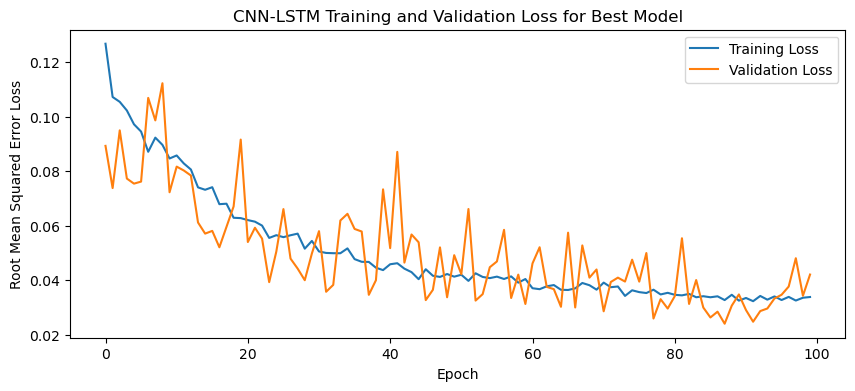

1/1 - 1s - loss: 0.0473 - 1s/epoch - 1s/step
Test Loss: 0.04730125889182091
1/1 [==============================] - 0s 38ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

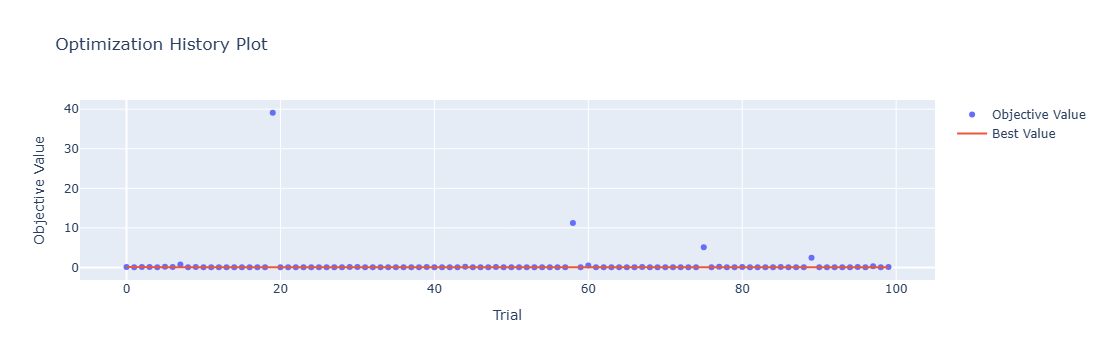

In [4]:
optuna.visualization.plot_optimization_history(study)

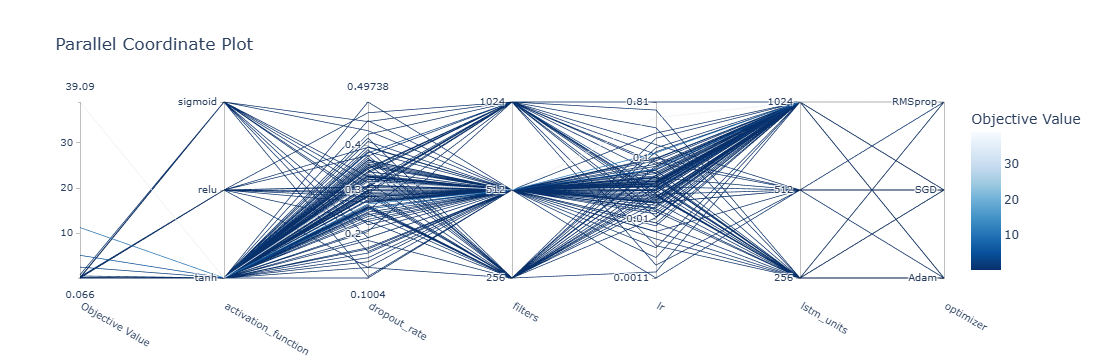

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

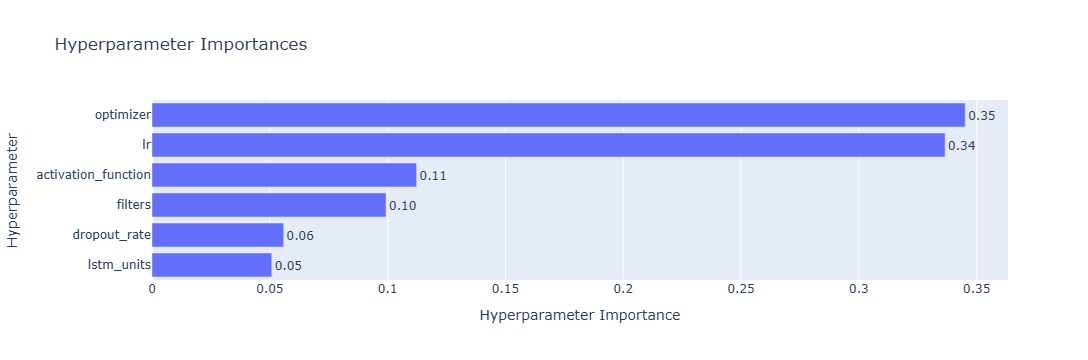

In [6]:
optuna.visualization.plot_param_importances(study)

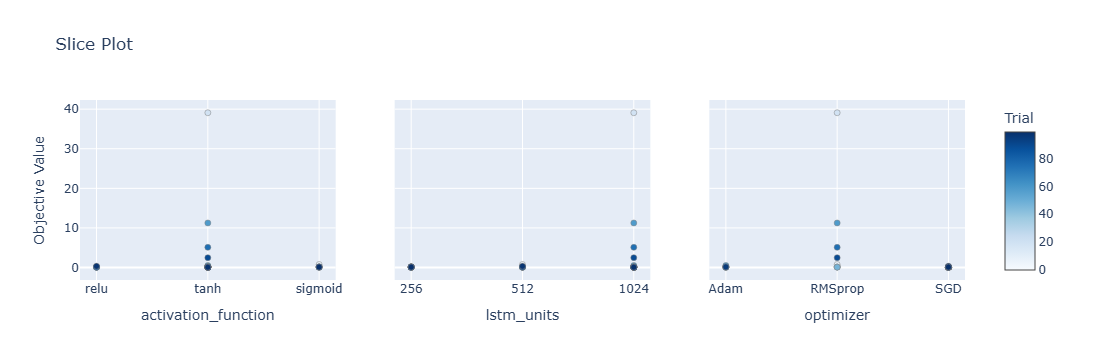

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

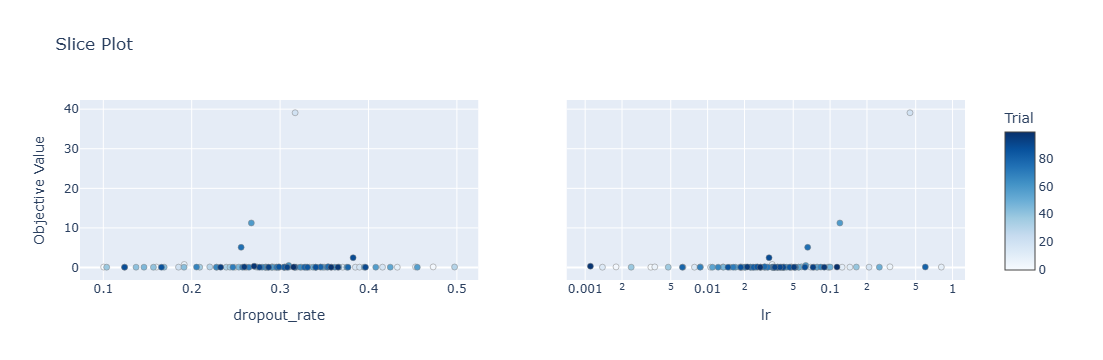

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 42s 270ms/step - loss: 0.1286 - accuracy: 0.8690 - mae: 0.1117 - rmse: 0.1286 - mape: 20.8019 - pearson: 0.8166 - val_loss: 0.1207 - val_accuracy: 1.0000 - val_mae: 0.1158 - val_rmse: 0.1207 - val_mape: 23.6659 - val_pearson: 0.5622
Epoch 2/100
84/84 [==============================] - 21s 253ms/step - loss: 0.1071 - accuracy: 0.8690 - mae: 0.0941 - rmse: 0.1071 - mape: 17.8565 - pearson: 0.8240 - val_loss: 0.0825 - val_accuracy: 1.0000 - val_mae: 0.0716 - val_rmse: 0.0825 - val_mape: 13.3578 - val_pearson: 0.9446
Epoch 3/100
84/84 [==============================] - 19s 220ms/step - loss: 0.1001 - accuracy: 0.8929 - mae: 0.0867 - rmse: 0.1001 - mape: 16.5645 - pearson: 0.8448 - val_loss: 0.1386 - val_accuracy: 1.0000 - val_mae: 0.1188 - val_rmse: 0.1386 - val_mape: 21.9355 - val_pearson: 0.9244
Epoch 4/100
84/84 [==============================] - 19s 229ms/step - loss: 0.0898 - accuracy: 0.8929 - mae: 0.0775 - rmse: 0.0898 - mape: 14.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 18s 211ms/step - loss: 0.0321 - accuracy: 0.9762 - mae: 0.0281 - rmse: 0.0321 - mape: 5.6006 - pearson: 0.9392 - val_loss: 0.0460 - val_accuracy: 0.9000 - val_mae: 0.0415 - val_rmse: 0.0460 - val_mape: 9.4092 - val_pearson: 0.9558
Epoch 86/100
84/84 [==============================] - 15s 178ms/step - loss: 0.0348 - accuracy: 0.9524 - mae: 0.0300 - rmse: 0.0348 - mape: 5.9672 - pearson: 0.9159 - val_loss: 0.0350 - val_accuracy: 0.8000 - val_mae: 0.0296 - val_rmse: 0.0350 - val_mape: 7.1415 - val_pearson: 0.8325
Epoch 87/100
84/84 [==============================] - 14s 166ms/step - loss: 0.0334 - accuracy: 0.9524 - mae: 0.0284 - rmse: 0.0334 - mape: 5.6935 - pearson: 0.9434 - val_loss: 0.0416 - val_accuracy: 0.8000 - val_mae: 0.0363 - val_rmse: 0.0416 - val_mape: 8.4049 - val_pearson: 0.8239
Epoch 88/100
84/84 [==============================] - 12s 146ms/step - loss: 0.0338 - accuracy: 0.9643 - mae: 0.0295 - rmse: 0.0338 - mape: 6.0243 - pearson: 

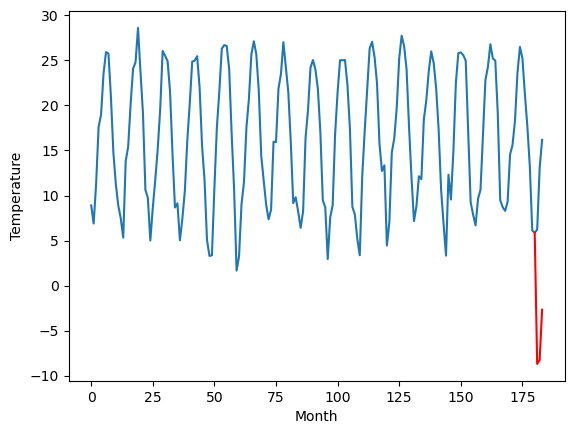

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.42		9.37		0.95
4.70		5.14		0.44
16.67		16.53		-0.14
[180, 181, 182, 183]
[3.2, 9.373602889180184, 5.136920474171639, 16.533976100087166]


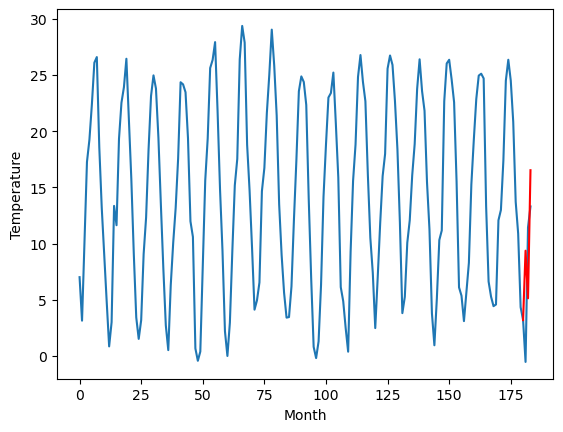

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.30		9.06		-1.24
12.60		10.24		-2.36
13.75		12.06		-1.69
[180, 181, 182, 183]
[8.48, 9.062535655647515, 10.241914522796868, 12.05623461022973]


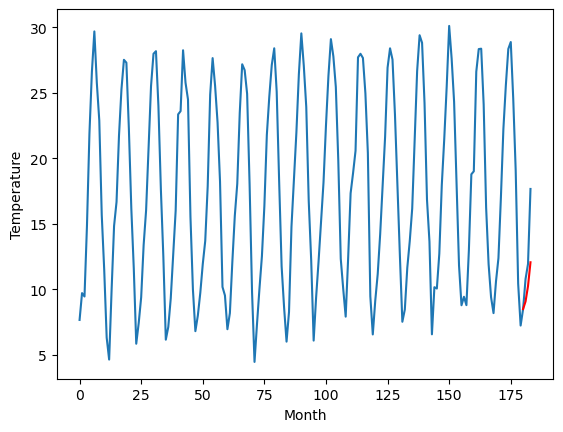

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.74		2.24		0.50
0.42		0.82		0.40
10.63		9.01		-1.62
[180, 181, 182, 183]
[1.55, 2.2433367490768434, 0.8203827857971193, 9.005938243865966]


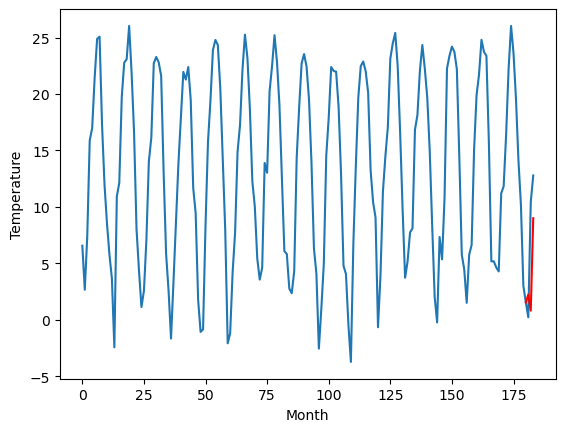

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.43		8.36		0.93
3.56		3.83		0.27
16.64		15.84		-0.80
[180, 181, 182, 183]
[1.08, 8.36388453245163, 3.8287974238395694, 15.839496695995331]


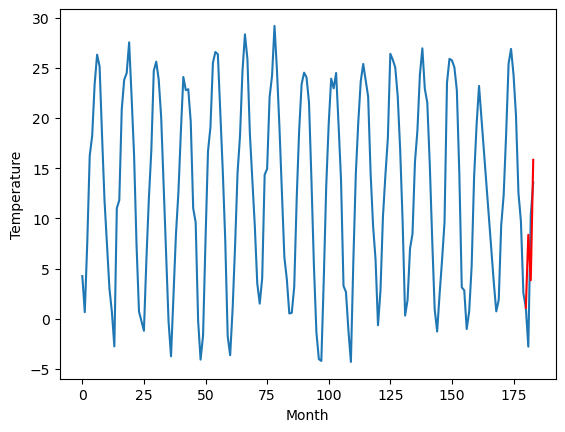

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.57		6.15		0.58
2.85		2.62		-0.23
14.18		13.44		-0.74
[180, 181, 182, 183]
[0.21, 6.151552219390869, 2.6224756431579586, 13.440353412628173]


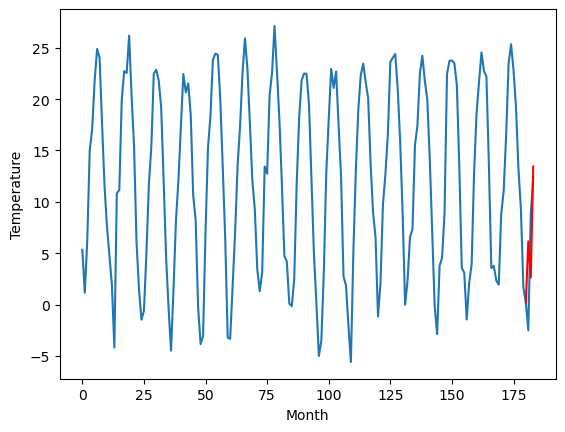

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.92		7.59		-0.33
8.02		7.66		-0.36
10.99		12.00		1.01
[180, 181, 182, 183]
[-8.22, 7.586115741729737, 7.663203196227551, 11.996067480742932]


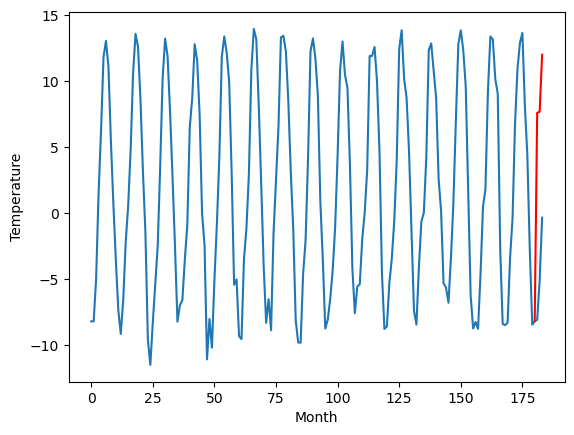

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.12		6.67		-0.45
9.97		7.50		-2.47
11.57		10.21		-1.36
[180, 181, 182, 183]
[10.04, 6.665194011926651, 7.495339907407761, 10.206473387479782]


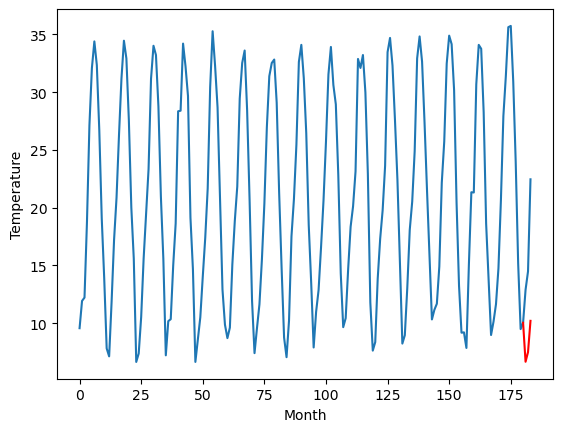

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.47		4.28		-1.19
6.40		5.72		-0.68
6.18		7.11		0.93
[180, 181, 182, 183]
[9.17, 4.280247220769525, 5.716512808576226, 7.105273017659783]


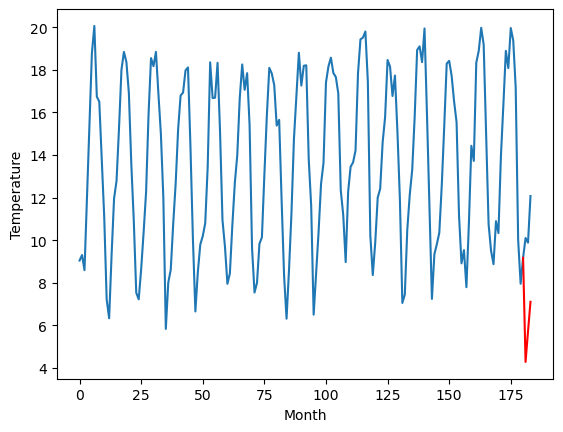

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.31		3.42		1.11
2.19		3.55		1.36
7.19		8.49		1.30
[180, 181, 182, 183]
[0.94, 3.418164210319519, 3.5505215096473695, 8.485316412448883]


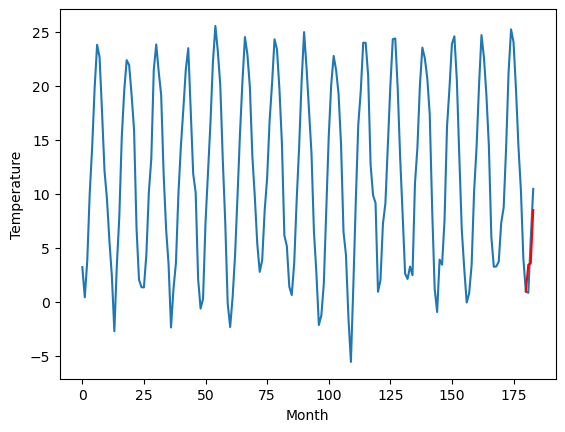

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-9.80		-10.06		-0.26
-10.60		-10.35		0.25
-3.41		-4.42		-1.01
[180, 181, 182, 183]
[-0.13, -10.056773056983948, -10.352442046403885, -4.417563220262528]


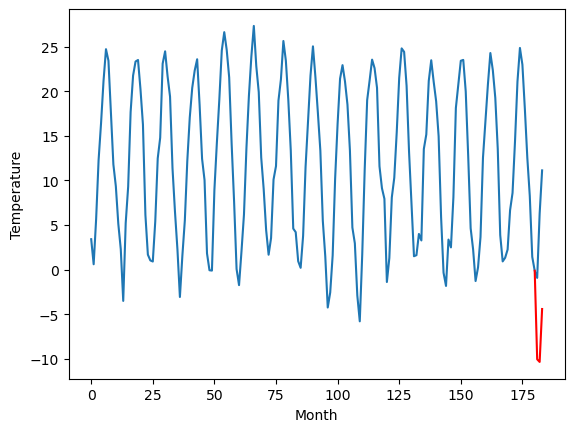

RangeIndex(start=1, stop=12, step=1)
[-8.520000000000001, 8.420000000000002, 10.299999999999999, 1.7399999999999998, 7.430000000000001, 5.5699999999999985, 7.92, 7.119999999999999, 5.4700000000000015, 2.3099999999999996, -9.8]
[-8.703390111923218, 9.373602889180184, 9.062535655647515, 2.2433367490768434, 8.36388453245163, 6.151552219390869, 7.586115741729737, 6.665194011926651, 4.280247220769525, 3.418164210319519, -10.056773056983948]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0   -8.52  -8.703390
1                 1    8.42   9.373603
2                 2   10.30   9.062536
3                 3    1.74   2.243337
4                 4    7.43   8.363885
5                 5    5.57   6.151552
6                 6    7.92   7.586116
7                 7    7.12   6.665194
8                 8    5.47   4.280247
9                 9    2.31   3.418164
10               10   -9.80 -10.056773


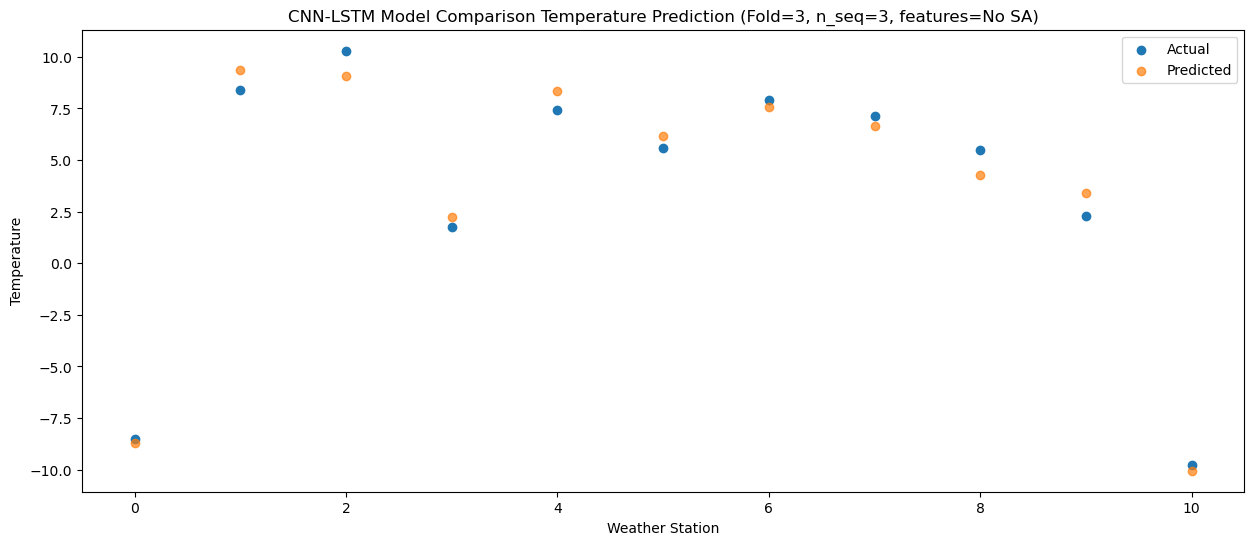

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0   -8.15  -8.266393
1                 1    4.70   5.136920
2                 2   12.60  10.241915
3                 3    0.42   0.820383
4                 4    3.56   3.828797
5                 5    2.85   2.622476
6                 6    8.02   7.663203
7                 7    9.97   7.495340
8                 8    6.40   5.716513
9                 9    2.19   3.550522
10               10  -10.60 -10.352442


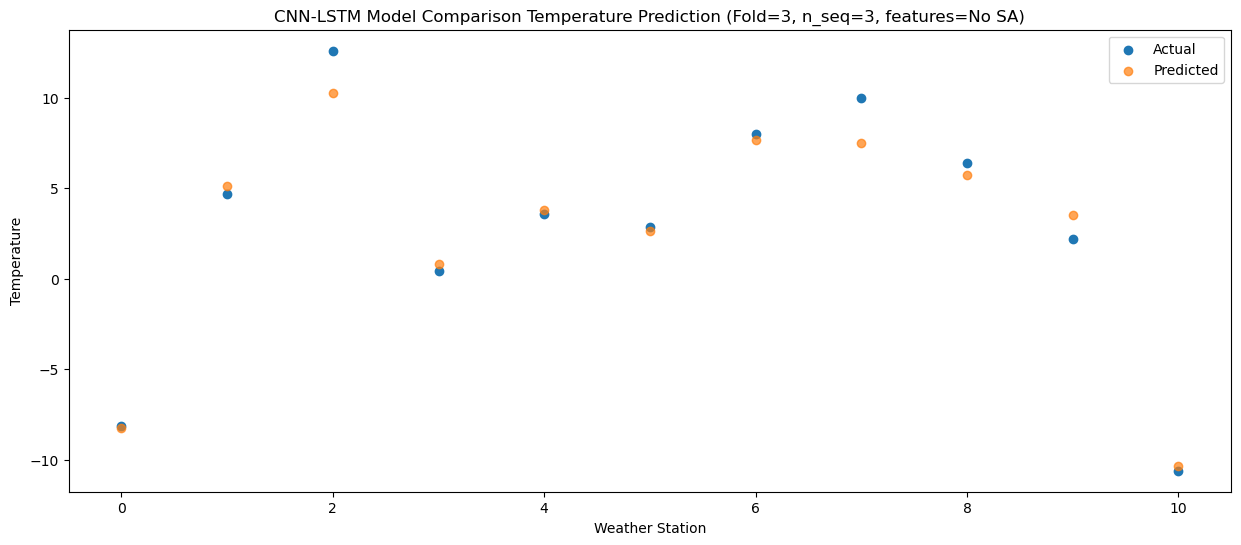

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   -1.35  -2.680470
1                 1   16.67  16.533976
2                 2   13.75  12.056235
3                 3   10.63   9.005938
4                 4   16.64  15.839497
5                 5   14.18  13.440353
6                 6   10.99  11.996067
7                 7   11.57  10.206473
8                 8    6.18   7.105273
9                 9    7.19   8.485316
10               10   -3.41  -4.417563


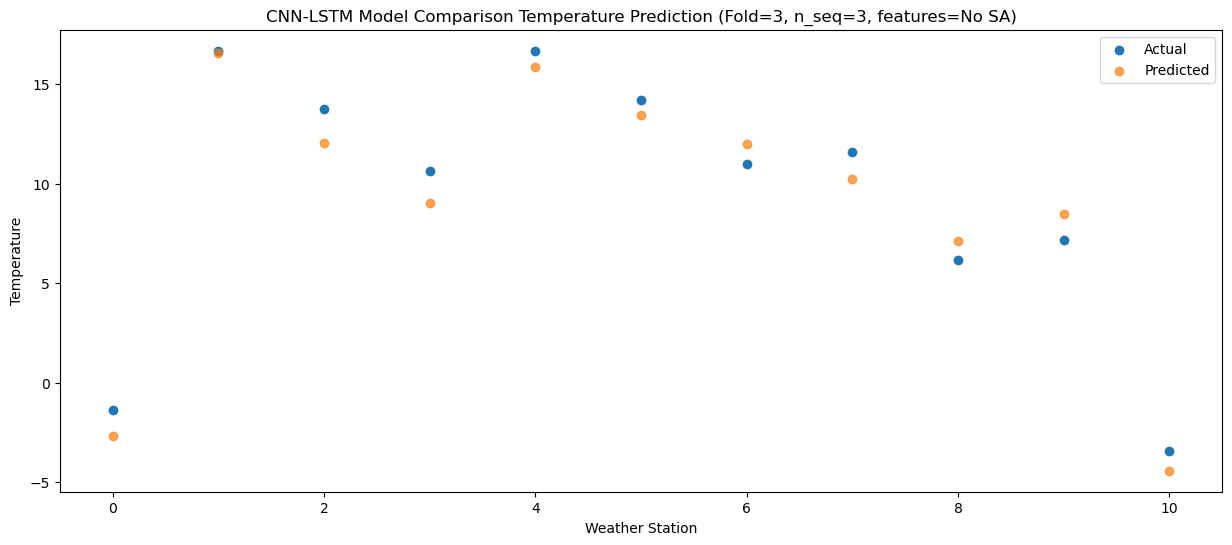

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 1, 512)            0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 1024)           6295552   
                                                                 
 dropout_10 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_7 (LSTM)               (None, 1024)              8392704   
                                                      

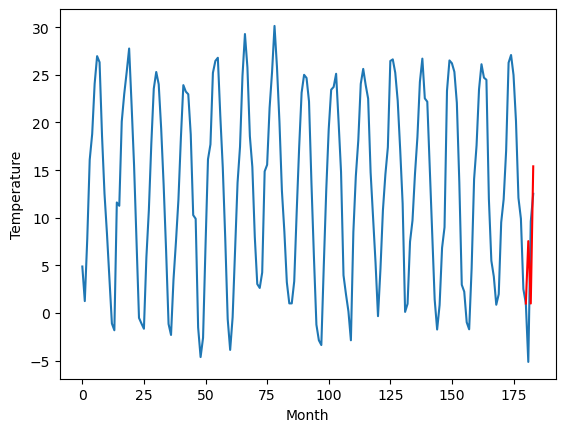

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.34		8.26		-0.08
11.77		9.71		-2.06
13.37		13.55		0.18
[180, 181, 182, 183]
[14.25, 8.262685730457306, 9.712650253772736, 13.546347572803498]


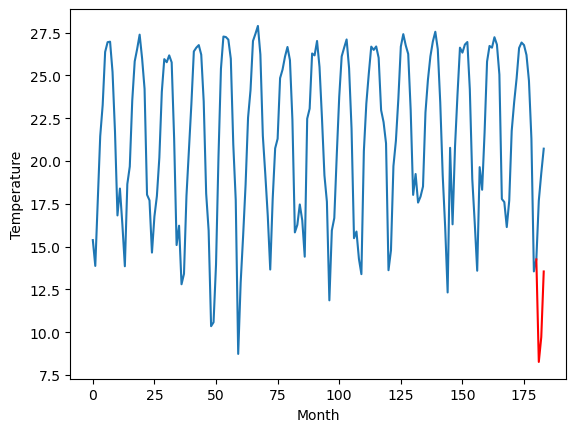

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		3.88		-0.41
2.37		1.49		-0.88
11.70		11.04		-0.66
[180, 181, 182, 183]
[9.06, 3.8844634091854093, 1.492586473226547, 11.038043359518051]


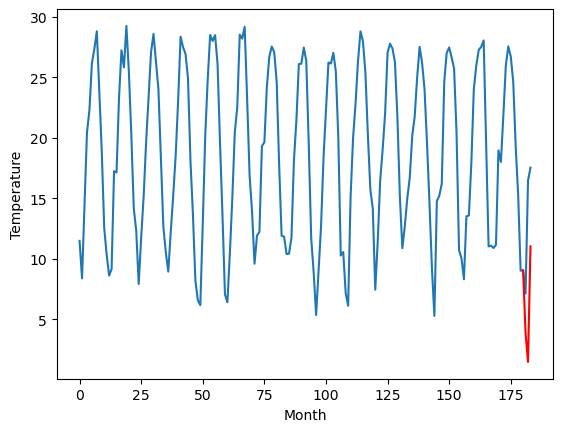

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.70		2.65		-0.05
-0.76		-2.07		-1.31
10.20		9.96		-0.24
[180, 181, 182, 183]
[7.48, 2.650931890010834, -2.067167227268219, 9.960111672878266]


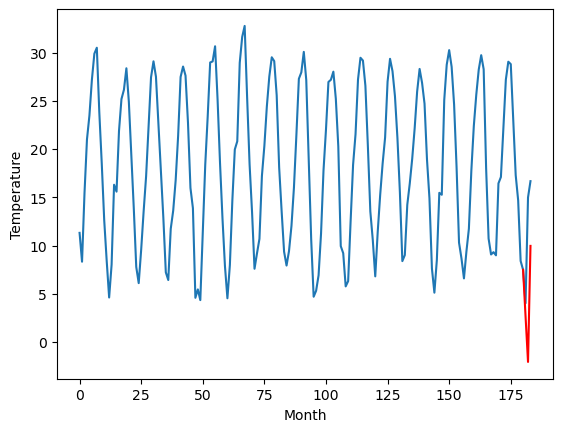

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.29		3.93		-0.36
0.40		-0.81		-1.21
11.32		11.20		-0.12
[180, 181, 182, 183]
[7.33, 3.9349330210685727, -0.8133789753913883, 11.19787342786789]


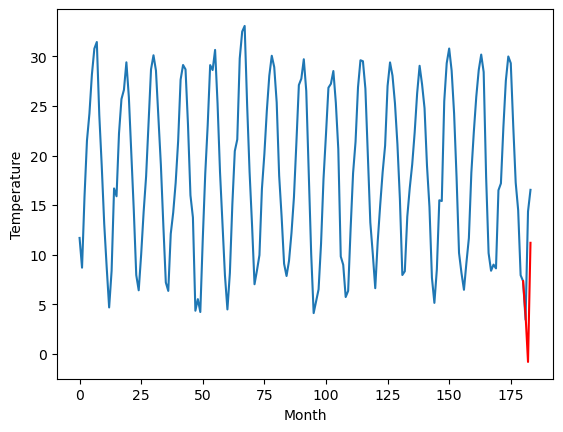

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.28		15.18		0.90
12.71		12.68		-0.03
21.96		21.41		-0.55
[180, 181, 182, 183]
[6.59, 15.179467742443085, 12.677367990016938, 21.406949822902682]


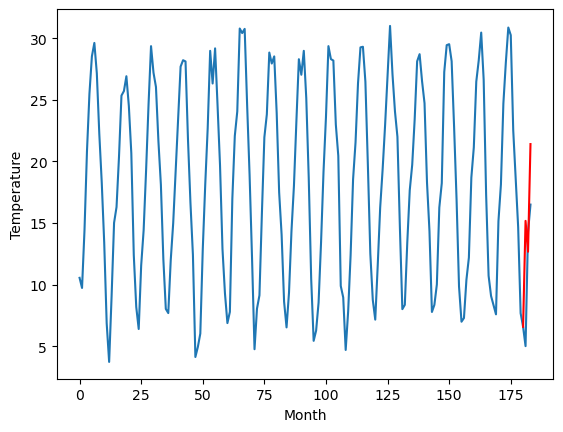

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.72		11.10		-0.62
12.39		10.53		-1.86
18.79		18.09		-0.70
[180, 181, 182, 183]
[6.04, 11.098926832675934, 10.531353166103363, 18.088015725612642]


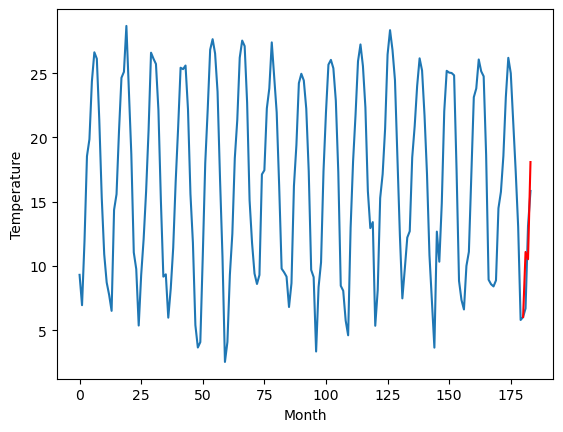

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.64		10.07		0.43
6.03		5.19		-0.84
18.30		17.85		-0.45
[180, 181, 182, 183]
[3.13, 10.07170837879181, 5.187257943153382, 17.8482753610611]


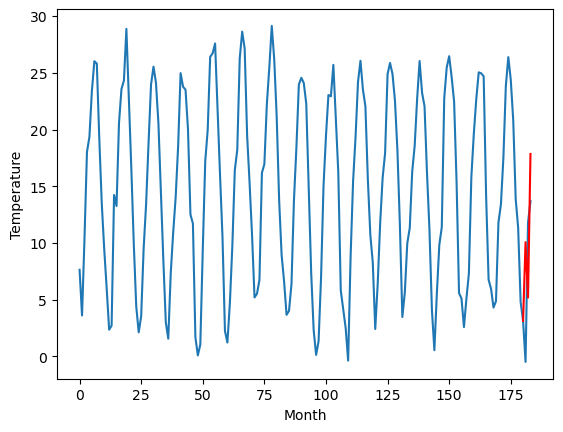

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.11		9.79		-0.32
6.75		5.22		-1.53
18.72		17.57		-1.15
[180, 181, 182, 183]
[-0.29, 9.79092794895172, 5.221314015388488, 17.574339451789854]


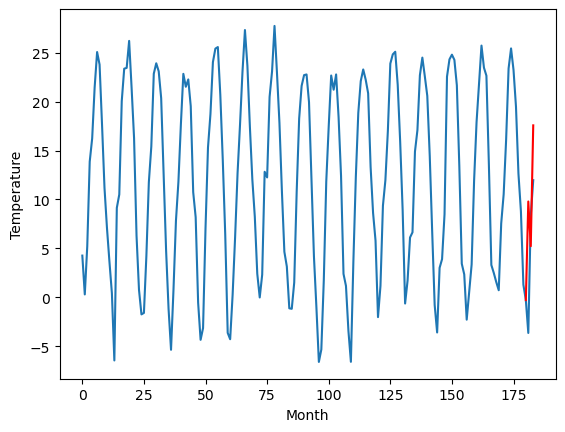

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		8.48		-0.05
4.09		2.40		-1.69
17.95		16.49		-1.46
[180, 181, 182, 183]
[-1.03, 8.484697160720826, 2.397403059005738, 16.487282094955447]


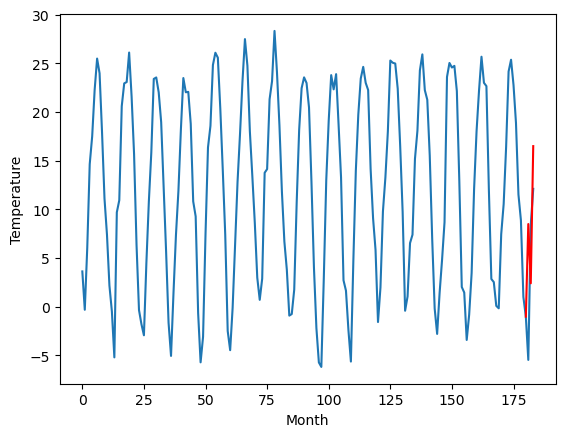

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.40		7.17		-0.23
5.16		3.72		-1.44
15.05		14.09		-0.96
[180, 181, 182, 183]
[-2.29, 7.171994276046753, 3.72256142616272, 14.092392511367798]


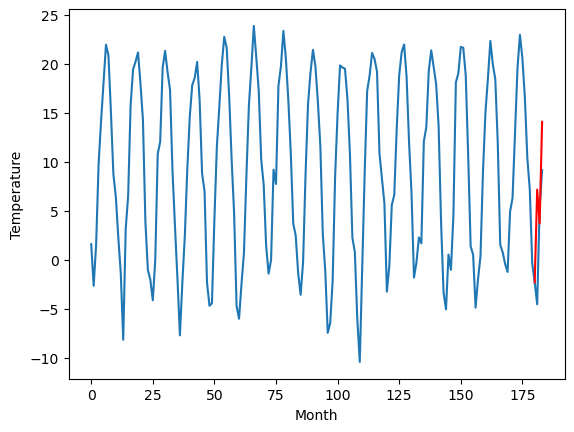

RangeIndex(start=1, stop=12, step=1)
[7.810000000000001, 8.339999999999998, 4.290000000000002, 2.7000000000000006, 4.289999999999999, 14.280000000000001, 11.719999999999999, 9.64, 10.11, 8.53, 7.4]
[7.55461651802063, 8.262685730457306, 3.8844634091854093, 2.650931890010834, 3.9349330210685727, 15.179467742443085, 11.098926832675934, 10.07170837879181, 9.79092794895172, 8.484697160720826, 7.171994276046753]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    7.81   7.554617
1                 1    8.34   8.262686
2                 2    4.29   3.884463
3                 3    2.70   2.650932
4                 4    4.29   3.934933
5                 5   14.28  15.179468
6                 6   11.72  11.098927
7                 7    9.64  10.071708
8                 8   10.11   9.790928
9                 9    8.53   8.484697
10               10    7.40   7.171994


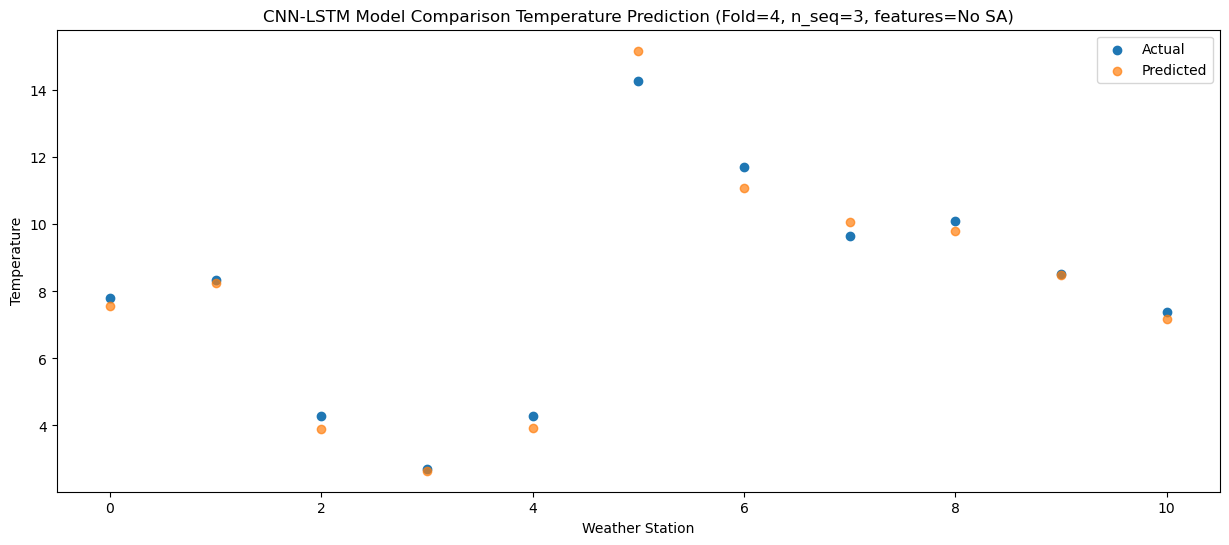

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    1.68   1.008841
1                 1   11.77   9.712650
2                 2    2.37   1.492586
3                 3   -0.76  -2.067167
4                 4    0.40  -0.813379
5                 5   12.71  12.677368
6                 6   12.39  10.531353
7                 7    6.03   5.187258
8                 8    6.75   5.221314
9                 9    4.09   2.397403
10               10    5.16   3.722561


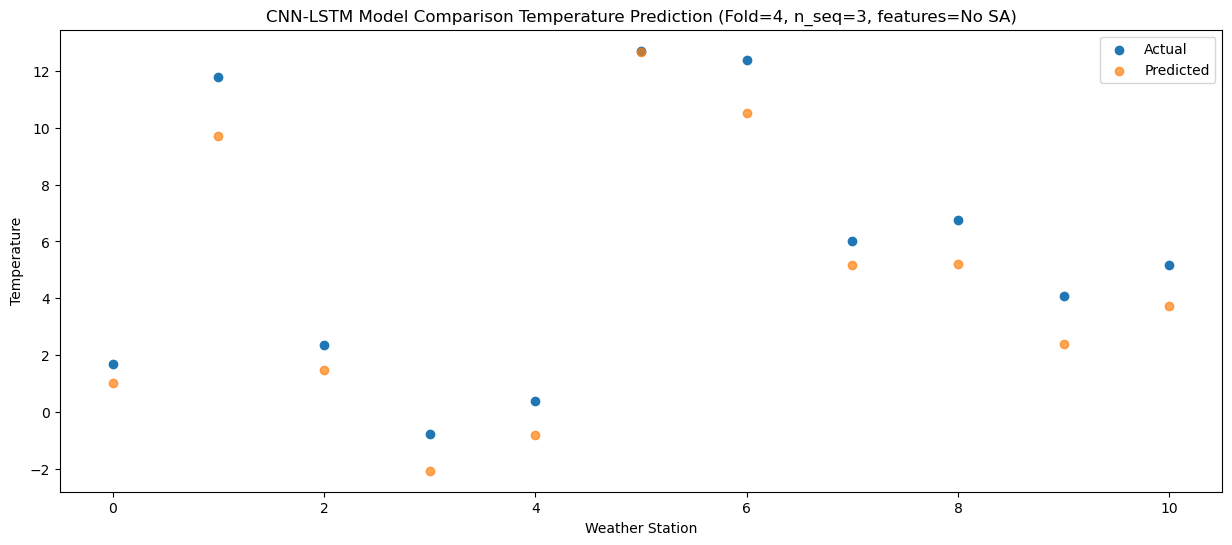

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0   16.41  15.399316
1                 1   13.37  13.546348
2                 2   11.70  11.038043
3                 3   10.20   9.960112
4                 4   11.32  11.197873
5                 5   21.96  21.406950
6                 6   18.79  18.088016
7                 7   18.30  17.848275
8                 8   18.72  17.574339
9                 9   17.95  16.487282
10               10   15.05  14.092393


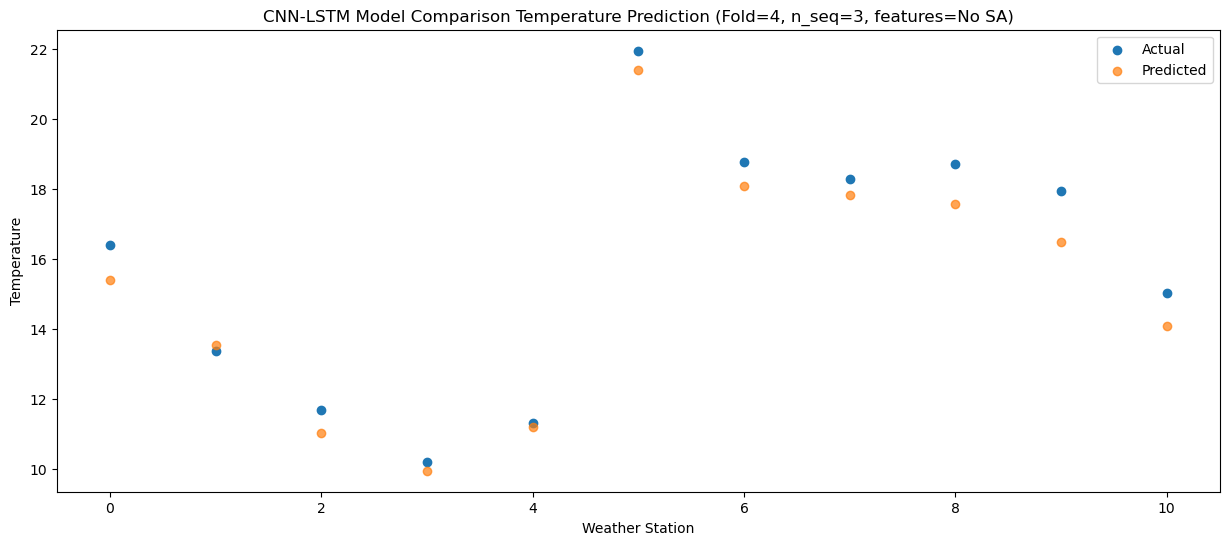

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 1024)           6295552   
                                                                 
 dropout_13 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_9 (LSTM)               (None, 1024)              8392704   
                                                      

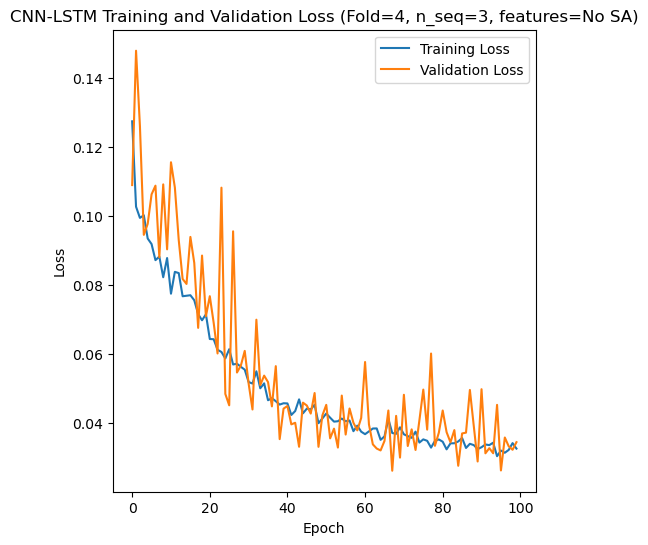

[[1.0804771793089007, 1.0081204486106452, 0.8852856220022589], [1.0587269475269203, 0.9338629696114081, 1.9462798749313803], [0.7926298131358209, 1.7292145787905158, 2.1195299451789653], [0.7957728532673859, 1.1552270460773868, 1.1639856679801233], [0.4157283355668218, 1.35068378001679, 0.7940130057885822]]
[[0.9629907918247312, 0.8495908110521058, 0.7412650842287346], [1.0312806812199675, 0.8164139173112134, 1.8440532822094189], [0.5873748499425973, 1.2958259984309022, 1.434143755463037], [0.7033282853866164, 0.8119206829301336, 1.083837993571703], [0.3351817576451733, 1.2290191610292955, 0.68034070611]]
[[0.10218430774603897, 0.14424243312219495, 0.04491735763727298], [0.10392370057844126, 0.089528261184189, 0.10822342518566018], [0.07028884725434828, 0.17512387983985275, 0.11328981537691338], [0.14579634936715588, 0.2224649376409316, 0.20042442278742703], [0.04235329765565374, 0.6281033774724614, 0.04174625426154206]]
[[0.8133204538696982, 0.9074137249862758, 0.8953312600752845], [0

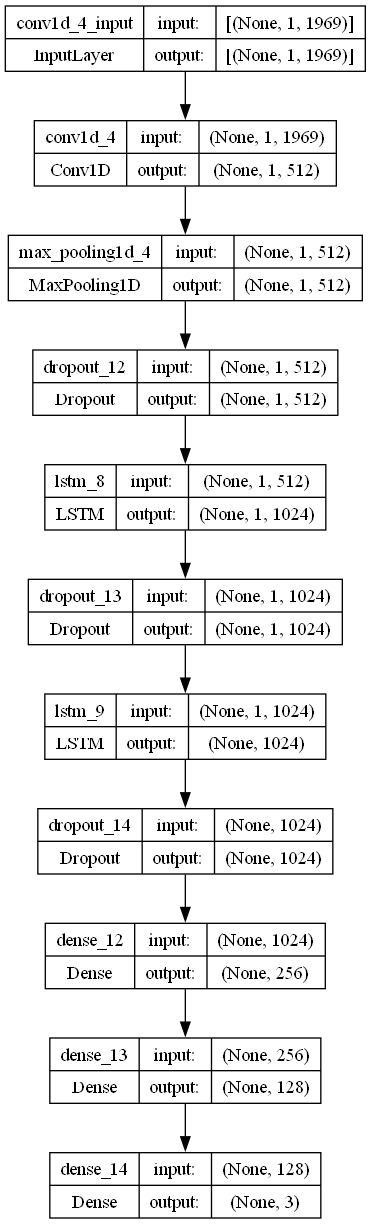

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.0413757666818497
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.1566864437768293

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with a CNN-LSTM model,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S3_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)